In [8]:
!pip install torch torchvision matplotlib numpy


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os


In [10]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]


In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [12]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []

epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 784).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f}")


Epoch 1/30 | Loss: 164.4868
Epoch 2/30 | Loss: 121.5088
Epoch 3/30 | Loss: 114.5485
Epoch 4/30 | Loss: 111.5145
Epoch 5/30 | Loss: 109.8437
Epoch 6/30 | Loss: 108.6342
Epoch 7/30 | Loss: 107.8229
Epoch 8/30 | Loss: 107.1588
Epoch 9/30 | Loss: 106.7037
Epoch 10/30 | Loss: 106.2606
Epoch 11/30 | Loss: 105.8757
Epoch 12/30 | Loss: 105.5946
Epoch 13/30 | Loss: 105.3289
Epoch 14/30 | Loss: 105.1106
Epoch 15/30 | Loss: 104.8912
Epoch 16/30 | Loss: 104.6982
Epoch 17/30 | Loss: 104.5341
Epoch 18/30 | Loss: 104.3433
Epoch 19/30 | Loss: 104.2016
Epoch 20/30 | Loss: 104.0741
Epoch 21/30 | Loss: 103.9451
Epoch 22/30 | Loss: 103.7734
Epoch 23/30 | Loss: 103.7334
Epoch 24/30 | Loss: 103.6097
Epoch 25/30 | Loss: 103.4804
Epoch 26/30 | Loss: 103.3871
Epoch 27/30 | Loss: 103.2895
Epoch 28/30 | Loss: 103.1856
Epoch 29/30 | Loss: 103.1025
Epoch 30/30 | Loss: 103.0559


In [14]:
os.makedirs("vae_generated_samples", exist_ok=True)

model.eval()
with torch.no_grad():
    z = torch.randn(25, 20).to(device)
    samples = model.decode(z).view(-1, 1, 28, 28)
    save_image(samples, "vae_generated_samples/generated.png", nrow=5)


In [15]:
os.makedirs("vae_reconstructions", exist_ok=True)

data, _ = next(iter(test_loader))
data = data.view(-1, 784).to(device)

with torch.no_grad():
    recon, _, _ = model(data)
    recon = recon.view(-1, 1, 28, 28)

save_image(data.view(-1,1,28,28)[:25], "vae_reconstructions/original.png", nrow=5)
save_image(recon[:25], "vae_reconstructions/reconstructed.png", nrow=5)


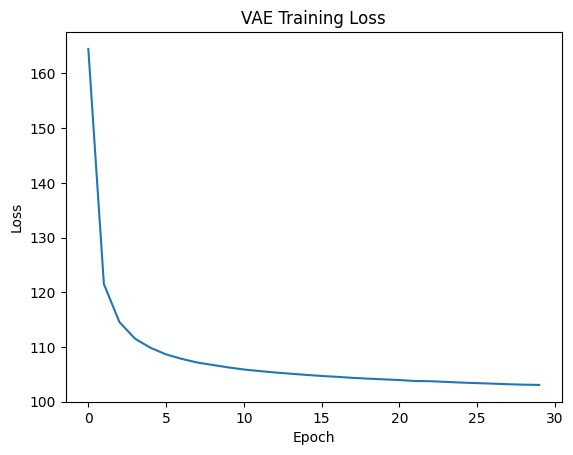

In [16]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()


In [17]:
!zip -r vae_generated_samples.zip vae_generated_samples
!zip -r vae_reconstructions.zip vae_reconstructions


  adding: vae_generated_samples/ (stored 0%)
  adding: vae_generated_samples/generated.png (deflated 3%)
  adding: vae_reconstructions/ (stored 0%)
  adding: vae_reconstructions/original.png (deflated 3%)
  adding: vae_reconstructions/reconstructed.png (deflated 4%)
